In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

%matplotlib inline

# read dataset
df = pd.read_csv("../data_for_student_case.csv")

# set cvc
df['cvcresponsecode'].ix[df['cvcresponsecode']>3] = 3

# change currency
df['amount'].ix[df['currencycode'] == 'MXN'] = df['amount'].ix[df['currencycode'] == 'MXN'] * 0.052131
df['amount'].ix[df['currencycode'] == 'AUD'] = df['amount'].ix[df['currencycode'] == 'AUD'] * 0.7349
df['amount'].ix[df['currencycode'] == 'NZD'] = df['amount'].ix[df['currencycode'] == 'NZD'] * 0.68966
df['amount'].ix[df['currencycode'] == 'GBP'] = df['amount'].ix[df['currencycode'] == 'GBP'] * 1.292625
df['amount'].ix[df['currencycode'] == 'SEK'] = df['amount'].ix[df['currencycode'] == 'SEK'] * 0.112851

# change currency code to make it comparable
df['currencycode'].ix[df['currencycode'] == 'MXN'] = 'MX'
df['currencycode'].ix[df['currencycode'] == 'AUD'] = 'AU'
df['currencycode'].ix[df['currencycode'] == 'NZD'] = 'NZ'
df['currencycode'].ix[df['currencycode'] == 'GBP'] = 'GB'
df['currencycode'].ix[df['currencycode'] == 'SEK'] = 'SE'

# deal with 'nan'
df['issuercountrycode'].fillna('other',inplace=True)
df['shoppercountrycode'].fillna('other',inplace=True)
df['bin'].fillna(1,inplace=True)

# drop 'Refused'
df = df[df['simple_journal'] != 'Refused']
df['simple_journal'].ix[df['simple_journal'] == 'Settled'] = 1
df['simple_journal'].ix[df['simple_journal'] == 'Chargeback'] = 0

# verificationcodesupplied True:1, False:0, unknown:2
df['cardverificationcodesupplied'].ix[df['cardverificationcodesupplied'] == True] = 1
df['cardverificationcodesupplied'].ix[df['cardverificationcodesupplied'] == False] = 0
df['cardverificationcodesupplied'].fillna(2,inplace=True)

# extract weekday and hour from creationdate
df['creationdate'] = pd.to_datetime(df['creationdate'])
df['cweekday'] = df['creationdate'].dt.weekday_name
df['chour'] = df['creationdate'].dt.hour
df['chour'].apply(pd.to_numeric)

# create issue_shopper
df['issue_shopper'] = df['issuercountrycode'] == df['shoppercountrycode']
df['issue_shopper'].ix[df['issue_shopper'] == True] = 1.0
df['issue_shopper'].ix[df['issue_shopper'] == False] = 0.0

# create issue_currency
df['issue_currency'] = df['issuercountrycode'] == df['currencycode']
df['issue_currency'].ix[df['issue_currency'] == True] = 1.0
df['issue_currency'].ix[df['issue_currency'] == False] = 0.0

# create shopper_currency
df['shopper_currency'] = df['shoppercountrycode'] == df['currencycode']
df['shopper_currency'].ix[df['shopper_currency'] == True] = 1.0
df['shopper_currency'].ix[df['shopper_currency'] == False] = 0.0

# drop features
df = df.drop(['bin', 'shoppercountrycode', 'issuercountrycode', 'txid', 'bookingdate', 'creationdate', 'mail_id', 'ip_id', 'card_id'], axis=1)

dummy_features = ['txvariantcode', 'currencycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode', 'cweekday']

for feature in dummy_features:

    just_dummies = pd.get_dummies(df[feature],prefix=feature+'_')

    df = pd.concat([df, just_dummies], axis=1)      
    df.drop([feature], inplace=True, axis=1)

df = df.reset_index(drop=True)
    
df.sample(5)

/Users/shijianzhong/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,amount,simple_journal,chour,issue_shopper,issue_currency,shopper_currency,txvariantcode__electron,txvariantcode__mc,txvariantcode__mccredit,txvariantcode__mcdebit,...,accountcode__MexicoAccount,accountcode__SwedenAccount,accountcode__UKAccount,cweekday__Friday,cweekday__Monday,cweekday__Saturday,cweekday__Sunday,cweekday__Thursday,cweekday__Tuesday,cweekday__Wednesday
209069,9300.436875,1,16,1.0,1.0,1.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
63645,3806.780625,1,15,1.0,1.0,1.0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
119896,3231.562500,1,18,1.0,1.0,1.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
48721,5293.299375,1,15,1.0,1.0,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
219731,7888.284900,1,4,1.0,1.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


#### Read dataset

#### set labels

In [2]:
from imblearn.over_sampling import  SMOTE 
sm = SMOTE(random_state=42)

#### Train classifier

In [3]:
from sklearn.model_selection import train_test_split

X_all = df.drop(['simple_journal'], axis=1).values
y_all = df['simple_journal']
y_all = np.asarray(y_all, dtype=int)
num_test = 0.5
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

confusion matrix:
[[     7    182]
 [    47 118282]]
confusion matrix(smote):
[[    11    178]
 [    58 118271]]


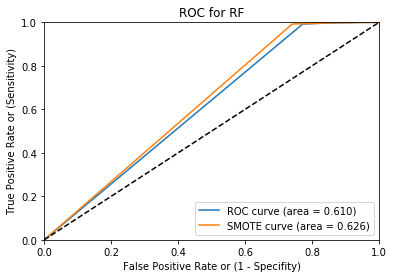

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_smote = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_smote.fit(X_smote, y_smote)

y_predict = rf.predict_proba(X_test)[:, 1]
y_predict_smote = rf_smote.predict_proba(X_test)[:, 1]

print('confusion matrix:')
print(confusion_matrix(y_test, rf.predict(X_test)))
print('confusion matrix(smote):' )
print(confusion_matrix(y_test, rf_smote.predict(X_test)))

fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_predict_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot(fpr_smote, tpr_smote, label='SMOTE curve (area = %0.3f)' % roc_auc_smote)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC for RF')
plt.legend(loc="lower right")

plt.savefig('rf.eps')

confusion matrix:
[[     0    189]
 [     0 118329]]
confusion matrix(smote):
[[   172     17]
 [ 18117 100212]]


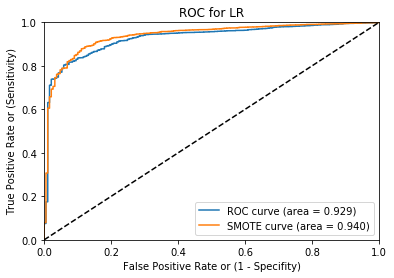

In [5]:
from sklearn.linear_model import LogisticRegression

# train 2 classifiers
lr = LogisticRegression()
lr_smote = LogisticRegression()
lr.fit(X_train, y_train)
lr_smote.fit(X_smote, y_smote)

# confusion matrix
#y_predict = lr.predict(X_test)
#y_predict_smote = lr_smote.predict(X_test)

y_predict = lr.predict_proba(X_test)[:, 1]
y_predict_smote = lr_smote.predict_proba(X_test)[:, 1]

print('confusion matrix:')
print(confusion_matrix(y_test, lr.predict(X_test)))
print('confusion matrix(smote):' )
print(confusion_matrix(y_test, lr_smote.predict(X_test)))


# roc plot

fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_predict_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot(fpr_smote, tpr_smote, label='SMOTE curve (area = %0.3f)' % roc_auc_smote)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC for LR')
plt.legend(loc="lower right")

plt.savefig('lr.eps')

confusion matrix:
[[     0    189]
 [    10 118319]]
confusion matrix(smote):
[[    31    158]
 [  1506 116823]]


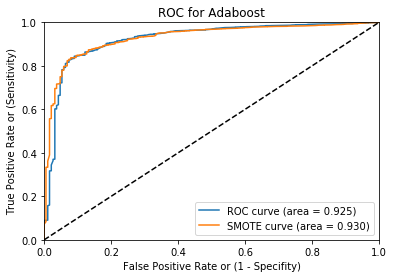

In [6]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada_smote = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_smote.fit(X_smote, y_smote)

# confusion matrix
# y_predict = ada.predict(X_test)
# y_predict_smote = ada_smote.predict(X_test)

y_predict = ada.predict_proba(X_test)[:, 1]
y_predict_smote = ada_smote.predict_proba(X_test)[:, 1]

print('confusion matrix:')
print(confusion_matrix(y_test, ada.predict(X_test)))
print('confusion matrix(smote):' )
print(confusion_matrix(y_test, ada_smote.predict(X_test)))

# roc plot

fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_predict_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot(fpr_smote, tpr_smote, label='SMOTE curve (area = %0.3f)' % roc_auc_smote)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC for Adaboost')
plt.legend(loc="lower right")
plt.savefig('ada.eps')